# Seoul Bike Sharing Demand Prediction

In [207]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor

## Dataset

Το dataset που θα χρησιμοποιήσουμε υπάρχει στο UCI https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand. Τα δεδομένα αφορούν την ενοίκιαση ποδηλάτων στην πόλη Seoul και ο σκοπός είναι η πρόβλεψη του αριθμού ποδηλάτων που θα ενοικιαστούν κάθε ώρα, προκειμένου να οργανωθεί η διαθεσιμότητά τους. Τα χαρακτηριστικά που διαθέτουμε είναι τα εξής 13:

- Date: χρονιά-μήνας-μέρα
- Hour: ώρα της μέρας
- Temperature: θερμοκρασία σε βαθμούς Κελσίου
- Humidity: ποσοστό υγρασίας
- Windspeed: ταχύτητα αέρα σε m/s
- Visibility: ορατότητα στα 10 μέτρα
- Dew point temperature: θερμοκρασία σημείου δρόσου σε βαθμούς Κελσίου
- Solar radiation: ηλιακή ακτινοβολία σε MJ/m2
- Rainfall: βροχόπτωση σε mm
- Snowfall: χιονόπτωση σε cm
- Seasons: εποχή
- Holiday: αν είναι μέρα διακοπών ή όχι
- Functional Day: αν είναι εργάσιμη μέρα ή όχι

και η μεταβλητή προς πρόβλεψη είναι η:

- Rented Bike count: αριθμός ενοικιασμένων ποδηλάτων ανά ώρα

Το dataset αποτελείται από 8760 δείγματα και τα χαρακτηριστικά είναι μίξη κατηγορικών και αριθμητικών. Το σύμβολο °C στους βαθμούς Κελσίου δημιουργεί πρόβλημα κατά την ανάγνωση οπότε το διαγράφουμε από το αρχείο .csv.

In [208]:
# load data
data = pd.read_csv('data/SeoulBikeData.csv')

In [209]:
data.head()

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [210]:
data.shape

(8760, 14)

In [211]:
data.dtypes

Date                         object
Rented Bike Count             int64
Hour                          int64
Temperature(C)              float64
Humidity(%)                   int64
Wind speed (m/s)            float64
Visibility (10m)              int64
Dew point temperature(C)    float64
Solar Radiation (MJ/m2)     float64
Rainfall(mm)                float64
Snowfall (cm)               float64
Seasons                      object
Holiday                      object
Functioning Day              object
dtype: object

In [212]:
# Quick summary statistics of the dataset features
data.describe(include='all')

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
count,8760,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760,8760,8760
unique,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,2
top,16/03/2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,No Holiday,Yes
freq,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2208,8328,8465
mean,NaN,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068,NaN,NaN,NaN
std,NaN,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746,NaN,NaN,NaN
min,NaN,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000,NaN,NaN,NaN
50%,NaN,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000,NaN,NaN,NaN
75%,NaN,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000,NaN,NaN,NaN


Με τις παραπάνω εξόδους επιβεβαιώνουμε τον αριθμό δειγμάτων και χαρακτηριστικών, καθώς και τον τύπο τους. Στη συνέχεια, ελέγχουμε αν υπάρχουν απουσιάζουσες τιμές.

In [213]:
data.isnull().sum()

Date                        0
Rented Bike Count           0
Hour                        0
Temperature(C)              0
Humidity(%)                 0
Wind speed (m/s)            0
Visibility (10m)            0
Dew point temperature(C)    0
Solar Radiation (MJ/m2)     0
Rainfall(mm)                0
Snowfall (cm)               0
Seasons                     0
Holiday                     0
Functioning Day             0
dtype: int64

Παρατηρούμε πως δεν απουσιάζει καμία τιμή.

## Data Preprocessing

Πριν χωρίσουμε τα δεδομένα σε train-test θα κάνουμε κάποιες στοιχειώδεις επεξεργασίες, ώστε να μην επαναλαμβάνουμε την ίδια 
δουλειά και στο test set, χωρίς κίνδυνο για διαρροή πληροφορίας. Αρχικά μετονομάζουμε τα χαρακτηριστικά για διευκόλυνση.

In [214]:
data.rename(columns={'Date': 'date', 'Rented Bike Count': 'count', 'Hour': 'hour', 'Temperature(C)': 'temperature',
                     'Humidity(%)': 'humidity', 'Wind speed (m/s)': 'wind', 'Visibility (10m)': 'visibility',
                     'Dew point temperature(C)': 'dew_point', 'Solar Radiation (MJ/m2)': 'radiation',
                     'Rainfall(mm)': 'rainfall', 'Snowfall (cm)': 'snowfall', 'Seasons': 'season', 'Holiday': 'holiday',
                     'Functioning Day': 'functioning'}, inplace=True)

Στη συνέχεια, θα απομονώσουμε τη μέρα και τον μήνα από την ημερομηνία, ώστε να τα χρησιμοποιήσουμε ως χαρακτηριστικά, καθώς είναι δύσκολο να χρησιμοποιήσουμε την ημερομηνία όπως είναι.

In [215]:
data['month'] = pd.DatetimeIndex(data['date']).month
data['day'] = pd.DatetimeIndex(data['date']).day
data.drop(['date'], axis=1, inplace=True)

In [216]:
data.head()

,count,hour,temperature,humidity,wind,visibility,dew_point,radiation,rainfall,snowfall,season,holiday,functioning,month,day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1,12
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1,12
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,1,12
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1,12
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1,12


Στη συνέχεια, θα μετατρέψουμε σε ακεραίους τις κατηγορίες που είναι σε string, δηλαδή τις τιμές των χαρακτηριστικών season, holiday και functioning.

In [217]:
le = LabelEncoder()
for feature in ['season', 'holiday', 'functioning']:
    data[feature] = le.fit_transform(data[feature])

In [218]:
data.head()

,count,hour,temperature,humidity,wind,visibility,dew_point,radiation,rainfall,snowfall,season,holiday,functioning,month,day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,1,1,1,12
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,1,1,1,12
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,1,1,1,12
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,1,1,1,12
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,1,1,1,12


Τώρα θα μετατρέψουμε τον τύπο των κατηγορικών μεταβλητών, ώστε να αναπαριστούνται ως κατηγορικές. Αυτές είναι οι hour, season, holiday, functioning, month και day.

In [219]:
data['hour'] = data.hour.astype('category')
data['season'] = data.season.astype('category')
data['holiday'] = data.holiday.astype('category')
data['functioning'] = data.functioning.astype('category')
data['month'] = data.month.astype('category')
data['day'] = data.day.astype('category')

In [220]:
data.dtypes

count             int64
hour           category
temperature     float64
humidity          int64
wind            float64
visibility        int64
dew_point       float64
radiation       float64
rainfall        float64
snowfall        float64
season         category
holiday        category
functioning    category
month          category
day            category
dtype: object

Τώρα θα πρέπει να αποφασίσουμε πώς θα αντιμετωπίσουμε τις κατηγορικές μεταβλητές. Τα χαρακτηριστικά holiday και functioning είναι ήδη binary οπότε δεν μας απασχολούν. Τα χαρακτηριστικά hour, day και month δηλώνουν χρόνο, οπότε έχει νόημα να τα αφήσουμε όπως είναι και επίσης αν τα κάναμε one-hot encode θα εισάγαμε μεγάλο sparsity οπότε θα τα αφήσουμε έτσι. Το season, επίσης μπορούμε να το αφήσουμε ως έχει, αφού και αυτό ουσιαστικά δηλώνει χρόνο.

Δεν θα εξετάσουμε τη διακύμανση των δεδομένων, αφού έχουμε ήδη δει από τα στατιστικά πως δεν υπάρχει μηδενική διακύμανση και επίσης θα κάνουμε επιλογή χαρακτηριστικών με cross-validation. Επομένως, προχωρούμε στο διαχωρισμό του dataset σε train και test χρησιμοποιώντας το 30% για test όπως συνηθίζεται.

In [221]:
# split features and target variable in X and y
y = data['count']
X = data.drop(['count'], axis=1)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Οι τιμές του target count μπορεί να είναι πολύ μεγάλες. Από τα στατιστικά βλέπουμε πως το min είναι 0 ενώ το max πάνω από 3000. Γι' αυτό το λόγο θα μετασχηματίσουμε το target με τον μετασχηματισμό log1p και κατά την πρόβλεψη θα χρησιμοποιούμε τον αντίστροφο μετασχηματισμό expm1. Επίσης, ως μετρική αξιολόγησης θα χρησιμοποιήσουμε την Root Mean Square Logarithmic Error (RMSLE) που χρησιμεύει όταν θέλουμε να τιμωρήσουμε περισσότερο έναν predictor που προβλέπει μικρότερες τιμές απ' ότι θα πρεπε. Αυτό είναι σημαντικό στο πρόβλημά μας, αφού δεν θέλουμε να έχουμε έλλειψη διαθέσιμων ποδηλάτων.

In [222]:
# log transform
y_train = np.log1p(y_train)

In [223]:
def rmsle_score(y_true, y_pred):
    """Returns the root mean squared logarithmic error.
    """
    y_pred[y_pred < 0] = 0  # can't be negative because of the logarithm
    y_pred = np.expm1(y_pred)  # inverse transform of log1p

    return np.sqrt(mean_squared_log_error(y_true, y_pred))

Στη συνέχεια, κάνουμε cross-validate Lasso πάντα χρησιμοποιώντας την παράμετρο κανονικοποίησης alpha, όπου για μικρές τιμές η κανονικοποίηση είναι μικρότερη, ενώ για μεγάλες μεγαλύτερη. Στο cross-validation χρησιμοποιούμε negative mean squared error για score και 5 folds, αφού το dataset δεν είναι τόσο μικρό.

Αρχικά, εξετάζουμε την μορφή κανονικοποίησης των δεδομένων, μεταξύ καθόλου scaling, min-max scaler ή standard scaler. 

In [224]:
# no scaler
lasso = Lasso(alpha=1.0, max_iter=2000, random_state=0)
parameters = {'alpha': [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1]}
lasso_cv = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=5)
lasso_cv.fit(X_train, y_train)

print(lasso_cv.best_score_)
print(lasso_cv.best_params_)

-0.5270082810206048
{'alpha': 0.0001}


In [225]:
# standard scaler
lasso = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha=1.0, random_state=0))])
parameters = {'lasso__alpha':[1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1]}
lasso_cv = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=5)
lasso_cv.fit(X_train, y_train)

print(lasso_cv.best_score_)
print(lasso_cv.best_params_)

-0.5269780698568667
{'lasso__alpha': 0.0001}


In [226]:
# min-max scaler
lasso = Pipeline([('scaler', MinMaxScaler()), ('lasso', Lasso(alpha=1.0, random_state=0))])
parameters = {'lasso__alpha': [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1]}
lasso_cv = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=5)
lasso_cv.fit(X_train, y_train)

print(lasso_cv.best_score_)
print(lasso_cv.best_params_)

-0.526924411864566
{'lasso__alpha': 0.0001}


Δεν βλέπουμε μεγάλες διαφορές, αλλά θα χρησιμοποιήσουμε τον min-max scaler που φαίνεται λίγο καλύτερος. Επίσης, παρατηρούμε πως όταν κάνουμε scale τα δεδομένα κάνει πιο γρήγορα converge η Lasso, αφού χωρίς scale οι 1000 επαναλήψεις που είναι το default max δεν έφταναν.

In [227]:
# scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Feature Selection / Extraction

Στη συνέχεια κάνουμε feature selection χρησιμοποιώντας τη μέθοδο recursive feature elimination με cross-validation με το μοντέλο Lasso, ώστε να αφαιρέσουμε χαρακτηριστικά που με βάση τα βάρη του Lasso δεν είναι σημαντικά. Στο μοντέλο χρησιμοποιούμε το καλύτερο alpha που βρήκαμε πριν, δηλαδή 1e-4.

In [228]:
# feature selection
selector = RFECV(Lasso(alpha=1e-4, random_state=0), step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=5)
selector.fit(X_train, y_train)
print(selector.support_)
print(selector.ranking_)

[ True  True  True  True False  True False  True  True  True  True  True
  True False]
[1 1 1 1 4 1 2 1 1 1 1 1 1 3]


Παρατηρούμε πως οι μεταβλητές wind, dew point και day δεν χρειάζονται στο μοντέλο οπότε τις αφαιρούμε.

In [229]:
X_train.shape

(6132, 14)

In [230]:
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

In [231]:
X_train.shape

(6132, 11)

Μια τελευταία δοκιμή που θα κάνουμε είναι εξαγωγή χαρακτηριστικών με PCA, δοκιμάζοντας να μειώσουμε τη διάσταση.

In [232]:
lasso = Pipeline([('pca', PCA(n_components=4, random_state=0)), ('lasso', Lasso(alpha=1e-4, random_state=0))])
parameters = {'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'lasso__alpha': [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1]}
lasso_cv = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=5)
lasso_cv.fit(X_train, y_train)

print(lasso_cv.best_score_)
print(lasso_cv.best_params_)

-0.529777276172251
{'lasso__alpha': 1e-05, 'pca__n_components': 10}


Παρατηρούμε πως με μείωση της διάστασης με PCA δεν βελτιώνεται το αποτέλεσμα οπότε δεν θα προβούμε σε κάτι τέτοιο.

## Εκπαίδευση μοντέλων

Αφού τα δεδομένα είναι έτοιμα θα εκπαιδεύσουμε και βελτιστοποιήσουμε διαφορετικά μοντέλα. Για την ακρίβεια, θα χρησιμοποιήσουμε τα μοντέλα Lasso, Ridge, Elastic Net, SVM, Neural Network, Extra Trees και Hist Gradient Boosting. Σε κάθε μοντέλο κάνουμε δύο gridsearch, ένα με μεγαλύτερο εύρος τιμών και ένα με στενότερο/προσαρμοσμένο με βάση τα αποτελέσματα του προηγουμένου.

### Dataframes for results

Πριν εκπαιδεύσουμε τους αλγορίθμους φτιάχνουμε τις απαραίτητες δομές δεδομένων για να αποθηκεύουμε αποτελέσματα που μας ενδιαφέρουν για κάθε αλγόριθμο. Συγκεκριμένα, θα αποθηκεύουμε τη μετρική RMSLE για το test set, χρόνους εκτέλεσης τελικού fit και predict και τη μεταβολή RMSLE πριν και μετά τη βελτιστοποίηση.

In [233]:
# model names to use as index for the dataframes
model_names = ['Lasso', 'Ridge', 'Elastic Net', 'SVM', 'Neural Network', 'Extra Trees', 'Hist Gradient Boosting']
# store fit and predict time
times = pd.DataFrame(.0, index=model_names, columns=['Fit Time', 'Predict Time'])
# store RMSLE metric
metric = pd.DataFrame(.0, index=model_names, columns=['RMSLE'])
# the percentage change of RMSLE after tuning the model
rmsle_change = pd.DataFrame(.0, index=model_names, columns=['% RMSLE change'])   

def get_results(model, model_name, rmsle_default):
    """ Fit final model, predict test, print and store results
    """
    # fit model
    start = time.time()
    model.fit(X_train, y_train)  # fit
    end = time.time()
    fit_time = round(end - start, 4)  # fit time

    # predict
    start = time.time()
    y_pred = model.predict(X_test)  # predict
    end = time.time()
    predict_time = round(end - start, 4) # predict time

    # evaluation
    rmsle = round(rmsle_score(y_test, y_pred), 3)

    # percentage change
    change = round((rmsle - rmsle_default)/rmsle_default * 100, 2)

    print("Results for " + model_name + ":\n")
    print("RMSLE:", rmsle)
    print("Time to fit:", fit_time)
    print("Time to predict:", predict_time)
    print("Percentage of RMSLE change: " + str(change) + "%")
    
    times.loc[model_name]['Fit Time'] = fit_time
    times.loc[model_name]['Predict Time'] = predict_time
    metric.loc[model_name]['RMSLE'] = rmsle
    rmsle_change.loc[model_name]['% RMSLE change'] = change

### Lasso

Θα εκπαιδεύσουμε ένα μοντέλο Lasso. Οι παράμετροι που θα βελτιστοποιήσουμε είναι το alpha (L1 κανονικοποίηση) και το selection (αν τα coefficients ενημερώνονται τυχαία ή σειριακά σε κάθε επανάληψη).

In [234]:
# train with default parameters
model = Lasso(random_state=0)
model.fit(X_train, y_train)
rmsle_default = rmsle_score(y_test, model.predict(X_test))
print('RMSLE with default parameters:', rmsle_default)

RMSLE with default parameters: 1.5440566060213785


In [235]:
# first gridsearch
model = Lasso(alpha=1.0, max_iter = 2000, selection='cyclic', random_state=0)
parameters = {'alpha': [1e-6, 1e-5, 1e-4, 0.001, 0.005, 0.01, 0.1, 1], 'selection': ['cyclic', 'random']}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-0.5259641835812179
{'alpha': 0.0001, 'selection': 'random'}


Βλέπουμε πως δεν χρειάζεται άλλο gridsearch και η κανονικοποίηση L1 είναι 0.0001 και τα coefficients είναι καλύτερο να ενημερώνονται τυχαία σε κάθε επανάληψη.

In [236]:
# final model
model = Lasso(alpha=0.0001, max_iter=2000, selection='random', random_state=0)
get_results(model, 'Lasso', rmsle_default)

Results for Lasso:

RMSLE: 0.702
Time to fit: 0.0538
Time to predict: 0.001
Percentage of RMSLE change: -54.54%


## Ridge

Θα εκπαιδεύσουμε ένα μοντέλο Ridge. Οι παράμετροι που θα βελτιστοποιήσουμε είναι το alpha (L2 κανονικοποίηση) και τον solver (μέθοδος υπολογισμού των coefficients).

In [237]:
# train with default parameters
model = Ridge(random_state=0)
model.fit(X_train, y_train)
rmsle_default = rmsle_score(y_test, model.predict(X_test))
print('RMSLE with default parameters:', rmsle_default)

RMSLE with default parameters: 0.7034566252163705


In [238]:
# first gridsearch
model = Ridge(alpha=1.0, solver='auto', random_state=0)
parameters = {'alpha': [1e-4, 0.001, 0.01, 0.1, 1, 3, 5, 7, 10], 
              'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-0.525745343185104
{'alpha': 0.1, 'solver': 'sag'}


Βλέπουμε πως δεν χρειάζεται άλλο gridsearch και η κανονικοποίηση L2 είναι 0.1 και o solver ο sag (Stochastic Average Gradient descent).

In [239]:
# final model
model = Ridge(alpha=0.1, solver='sag', random_state=0)
get_results(model, 'Ridge', rmsle_default)

Results for Ridge:

RMSLE: 0.702
Time to fit: 0.0169
Time to predict: 0.001
Percentage of RMSLE change: -0.21%


### Elastic Net

Θα εκπαιδεύσουμε ένα μοντέλο Elastic Net. Οι παράμετροι που θα βελτιστοποιήσουμε είναι το alpha (συνδυασμός L1 και L2 κανονικοποίησης), το l1_ratio (ποσοστό L1 κανονικοποίησης όπου αν είναι 0 έχουμε μόνο L2, ενώ αν είναι 1 έχουμε μόνο L1) και το selection όπως και στη Lasso.

In [240]:
# train with default parameters
model = ElasticNet(random_state=0)
model.fit(X_train, y_train)
rmsle_default = rmsle_score(y_test, model.predict(X_test))
print('RMSLE with default parameters:', rmsle_default)

RMSLE with default parameters: 1.5440566060213785


In [241]:
# first gridsearch
model = ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=2000, selection='cyclic', random_state=0)
parameters = {'alpha': [1e-5, 1e-4, 0.001, 0.01, 0.1, 1, 2, 3], 'l1_ratio': [0, 0.2, 0.4, 0.6, 0.8, 1],
              'selection': ['cyclic', 'random']}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-0.5258297866706567
{'alpha': 0.0001, 'l1_ratio': 0.4, 'selection': 'cyclic'}


In [242]:
# second gridsearch
model = ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=2000, selection='cyclic', random_state=0)
parameters = {'alpha': [1e-5, 1e-4, 0.001], 'l1_ratio': [0.3, 0.4, 0.5]}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-0.5258285521758433
{'alpha': 0.0001, 'l1_ratio': 0.5}


Παρατηρούμε πως το μείγμα κανονικοποίησης είναι μισό μισό L1 και L2, ο βαθμός κανονικοποίησης 0.0001 και για την ενημέρωση των βαρών διατρέχονται σειριακά τα features σε κάθε επανάληψη.

In [243]:
# final model
model = ElasticNet(alpha=0.0001, l1_ratio=0.5, max_iter=2000, selection='cyclic', random_state=0)
get_results(model, 'Elastic Net', rmsle_default)

Results for Elastic Net:

RMSLE: 0.702
Time to fit: 0.0359
Time to predict: 0.0
Percentage of RMSLE change: -54.54%


### Support Vector Machine

Θα εκπαιδεύσουμε ένα SVM (Support Vector Machine). Οι παράμετροι που θα βελτιστοποιήσουμε είναι φυσικά ο kernel και το C (κανονικοποίηση ο βαθμός της οποίας είναι αντίστροφος του C).

In [244]:
# train with default parameters
model = SVR()
model.fit(X_train, y_train)
rmsle_default = rmsle_score(y_test, model.predict(X_test))
print('RMSLE with default parameters:', rmsle_default)

RMSLE with default parameters: 0.6161216990600423


In [245]:
# first gridsearch
model = SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, C=1.0)
parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [1, 10, 100, 1000]}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-0.2976519466277425
{'C': 1000, 'kernel': 'rbf'}


Βλέπουμε πως ο καλύτερος kernel είναι ο rbf και το C είναι 1000. Θα μπορούσαμε να εξετάσουμε και μικρότερο regularization, αλλά το cross-validation καθυστερεί πολύ οπότε θα κρατήσουμε αυτό.

In [246]:
# final model
model = SVR(kernel='rbf', C=1000)
get_results(model, 'SVM', rmsle_default)

Results for SVM:

RMSLE: 0.557
Time to fit: 37.0254
Time to predict: 0.2619
Percentage of RMSLE change: -9.6%


### Neural Network

Θα εκπαιδεύσουμε ένα απλό νευρωνικό δίκτυο (multi-layer perceptron). Η παράμετρος που θα βελτιστοποιήσουμε είναι μόνο η αρχιτεκτονική του δικτύου, δηλαδή ο αριθμός των νευρώνων και αν θα χρησιμοποιήσουμε 1 ή 2 hidden layers, αφού συνήθως δεν χρειάζονται περισσότερα. Οι υπόλοιπες σημαντικές παράμετροι θα μείνουν οι default, αφού εμπειρικά είναι οι καλύτερες, δηλαδή optimizer Adam με 0.001 learning rate και activation ReLu. Επίσης, θα χρησιμοποιήσουμε early stopping για αποφυγή overfitting και πιο γρήγορο cross-validation.

In [247]:
# train with default parameters
model = MLPRegressor(random_state=0)
model.fit(X_train, y_train)
rmsle_default = rmsle_score(y_test, model.predict(X_test))
print('RMSLE with default parameters:', rmsle_default)

RMSLE with default parameters: 0.6077506052579834


C:\Users\Vagelis\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [248]:
# first gridsearch
model = MLPRegressor(hidden_layer_sizes=100, batch_size=32, early_stopping=True, validation_fraction=0.1, n_iter_no_change=5, 
                     random_state=0)
parameters = {'hidden_layer_sizes': [(32,), (64,), (128,), (256,), (64, 32), (128, 64), (256, 128)]}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-0.24061856332892068
{'hidden_layer_sizes': (128, 64)}


Παρατηρούμε πως η καλύτερη αρχιτεκτονική είναι δύο hidden layers με 128 και 64 νευρώνες αντίστοιχα.

In [249]:
# final model
model = MLPRegressor(hidden_layer_sizes=(128, 64), batch_size=32, early_stopping=True, validation_fraction=0.1, 
                     n_iter_no_change=5, random_state=0)
get_results(model, 'Neural Network', rmsle_default)

Results for Neural Network:

RMSLE: 0.448
Time to fit: 13.447
Time to predict: 0.0239
Percentage of RMSLE change: -26.29%


### Extra Trees

Θα εκπαιδεύσουμε ένα μοντέλο Extra Trees (Extremely Randomized Trees). Οι παράμετροι που θα βελτιστοποιήσουμε είναι οι n_estimators (πόσα δέντρα θα φτιαχτούν), max_depth (το μέγιστο βάθος κάθε δέντρου για αποφυγή over-fitting) και max_features (πόσα χαρακτηριστικά θα ελέγχονται για την επιλογή του καλύτερου split).

In [250]:
# train with default parameters
model = ExtraTreesRegressor(random_state=0)
model.fit(X_train, y_train)
rmsle_default = rmsle_score(y_test, model.predict(X_test))
print('RMSLE with default parameters:', rmsle_default)

RMSLE with default parameters: 0.3928431740769239


In [251]:
# first gridsearch
model = ExtraTreesRegressor(n_estimators=100, max_depth=None, max_features='auto', n_jobs=5, random_state=0)
parameters = {'n_estimators': [50, 100, 150, 200], 'max_depth': [10, 30, 50, 70], 'max_features': [5, 7, 9, 11]}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-0.1664870673252306
{'max_depth': 50, 'max_features': 7, 'n_estimators': 200}


In [252]:
# second gridsearch
model = ExtraTreesRegressor(n_estimators=100, max_depth=None, max_features='auto', n_jobs=5, random_state=0)
parameters = {'n_estimators': [200, 250, 300], 'max_depth': [40, 50, 60], 'max_features': [6, 7, 8]}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-0.16637881059101275
{'max_depth': 40, 'max_features': 7, 'n_estimators': 300}


Παρατηρούμε πως πρέπει να φτιαχτούν 300 δέντρα των οποίων το μέγιστο βάθος είναι 40 και πρέπει να ελέγχονται 7 χαρακτηριστικά για την επιλογή split.

In [253]:
# final model
model = ExtraTreesRegressor(n_estimators=300, max_depth=40, max_features=7, n_jobs=5, random_state=0)
get_results(model, 'Extra Trees', rmsle_default)

Results for Extra Trees:

RMSLE: 0.389
Time to fit: 0.8622
Time to predict: 0.108
Percentage of RMSLE change: -0.98%


### Hist Gradient Boosting

Θα εκπαιδεύσουμε ένα μοντέλο Hist Gradient Boosting. Οι παράμετροι που θα βελτιστοποιήσουμε είναι το learning_rate, το max_leaf_nodes (για αποφυγή over-fitting) και το l2_regularization. Επίσης, θα χρησιμοποιήσουμε early stopping για αποφυγή over-fitting και πιο γρήγορο cross-validation.

In [254]:
# train with default parameters
model = HistGradientBoostingRegressor(random_state = 0)
model.fit(X_train, y_train)
rmsle_default = rmsle_score(y_test, model.predict(X_test))
print('RMSLE with default parameters:', rmsle_default)

RMSLE with default parameters: 0.4119074219467291


In [255]:
# first gridsearch
model = HistGradientBoostingRegressor(learning_rate=0.1, max_leaf_nodes=31, l2_regularization=0.0, early_stopping=True,
                                      validation_fraction=0.1, n_iter_no_change=5, random_state=0)
parameters = {'learning_rate': [0.001, 0.01, 0.1, 1], 'max_leaf_nodes': [10, 20, 30, 40, 50],
              'l2_regularization': [1e-4, 0.001, 0.01, 0.1, 1]}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-0.17915345696257004
{'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_leaf_nodes': 40}


In [256]:
# second gridsearch
model = HistGradientBoostingRegressor(learning_rate=0.1, max_leaf_nodes=31, l2_regularization=0.1, early_stopping=False, 
                                      random_state=0)
parameters = {'max_leaf_nodes': [35, 40, 45], 'max_iter': [100, 200, 300, 400]}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-0.16724813561636767
{'max_iter': 300, 'max_leaf_nodes': 35}


Παρατηρούμε πως η L2 κανονικοποίηση είναι 0.1, το learning_rate 0.1 και ο μέγιστος αριθμός φύλλων 35. Επίσης, κάναμε cross-validate και τον αριθμό επαναλήψεων χωρίς early stopping και είναι μέγιστος 300.

In [257]:
# final model
model = HistGradientBoostingRegressor(learning_rate=0.1, max_leaf_nodes=35, l2_regularization=0.1, max_iter=300)
get_results(model, 'Hist Gradient Boosting', rmsle_default)

Results for Hist Gradient Boosting:

RMSLE: 0.406
Time to fit: 2.975
Time to predict: 0.0219
Percentage of RMSLE change: -1.43%


## Αποτελέσματα και Σύγκριση

### Χρόνοι εκτέλεσης

Παρακάτω φαίνεται ο πίνακας με τους χρόνους εκπαίδευσης και πρόβλεψης των τελικών μοντέλων σε δευτερόλεπτα. Όπως ήταν αναμενόμενο το SVM είναι το πιο αργό και στις δύο περιπτώσεις, ενώ τα γραμμικά μοντέλα τα πιο γρήγορα με σχεδόν μηδενικό χρόνο πρόβλεψης. Το Νευρωνικό Δίκτυο αν και χρειάζεται πολύ χρόνο για εκπαίδευση, προβλέπει σχετικά γρήγορα. Επίσης, το μοντέλο Hist Gradient Boosting εκπαιδεύεται πιο αργά, αλλά προβλέπει πιο γρήγορα από το Extra Trees.

In [262]:
times

,Fit Time,Predict Time
Lasso,0.0538,0.0010
Ridge,0.0169,0.0010
Elastic Net,0.0359,0.0000
SVM,37.0254,0.2619
Neural Network,13.4470,0.0239
Extra Trees,0.8622,0.1080
Hist Gradient Boosting,2.9750,0.0219


### Μεταβολή Επίδοσης

Παρακάτω φαίνεται ο πίνακας με την ποσοστιαία μεταβολή του σφάλματος RMSLE πριν και μετά τη βελτιστοποίηση των μοντέλων. Βλέπουμε πως στην περίπτωση των μοντέλων Lasso και Elastic Net το σφάλμα μειώθηκε κατά περίπου 50%, ενώ το μοντέλο Ridge, καθώς και τα ensemble μοντέλα είχαν μικρή βελτίωση.

In [264]:
rmsle_change

,% RMSLE change
Lasso,-54.54
Ridge,-0.21
Elastic Net,-54.54
SVM,-9.60
Neural Network,-26.29
Extra Trees,-0.98
Hist Gradient Boosting,-1.43


### Αξιολόγηση

Στον παρακάτω πίνακα και barplot φαίνεται η αξιολόγηση των μοντέλων στο test set με το κριτήριο RMSLE. Βλέπουμε πως τα γραμμικά μοντέλα έχουν πολύ παρόμοια αποτελέσματα και μάλιστα όχι καλά, άρα οδηγούμαστε στο συμπέρασμα πως τα δεδομένα μας χρειάζονται πιο περίπλοκη μοντελοποίηση. Πράγματι, τα άλλα μοντέλα τα πήγαν καλύτερα, ειδικά τα ensemble μοντέλα όπως και ήταν αναμενόμενο, με το Extra Trees να έχει το καλύτερο score.

In [265]:
metric

,RMSLE
Lasso,0.702
Ridge,0.702
Elastic Net,0.702
SVM,0.557
Neural Network,0.448
Extra Trees,0.389
Hist Gradient Boosting,0.406


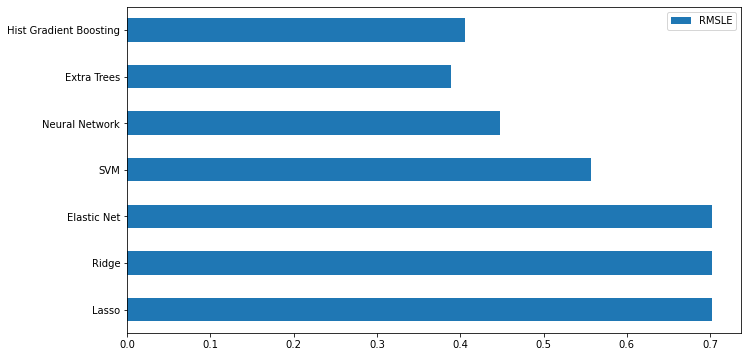

In [266]:
ax = metric.plot(kind='barh', figsize=(11, 6))